## 건축물의 화재 위험도 분석 및 예측 모델 제시

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import re

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import 

from imblearn.over_sampling import SMOTE
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance

from google.colab import drive
drive.mount('/content/drive')

conda install -c conda-forge imbalanced-learn

conda install -c conda-forge xgboost

!pip install xgboost

!pip install --upgrade scikit-learn --user

conda install -c conda-forge lightgbm

### 월별 평균 전처리

In [ ]:
# train.csv

df_train.drop(columns=['id'],inplace=True)
newmonth = ["avg_gas_01","avg_gas_02","avg_gas_03","avg_gas_04","avg_gas_05","avg_gas_06","avg_gas_07","avg_gas_08","avg_gas_09","avg_gas_10","avg_gas_11","avg_gas_12"]

# ele 월별 묶음 list 생성
ele_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      ele_energy_us_month[j-1].append("ele_engry_us_{}0{}".format(i,j))
    else:
      ele_energy_us_month[j-1].append("ele_engry_us_{}{}".format(i,j))
ele_energy_us_month

# gas 월별 묶음 list 생성
gas_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      gas_energy_us_month[j-1].append("gas_engry_us_{}0{}".format(i,j))
    else:
      gas_energy_us_month[j-1].append("gas_engry_us_{}{}".format(i,j))
gas_energy_us_month

df_train.iloc[:,17:137] = df_train.iloc[:,17:137].fillna(0) # ele 이랑 gas nan 값 0으로 채우기

In [ ]:
# 201401~201801 까지 5개년을 더해서 ele_engry_us_01 을 만듬. 이때 기록 있으면 count 증가해서 평균 만듦

gas_energy_us_m = []
ele_energy_us_m = []
for i in range(len(df_train)):
  j = 0
  months_g = []
  months_e = []
  for m in range(12):
    count_g = 0
    rec_value_g = 0
    count_e = 0
    rec_value_e = 0
    for y in range(5):
      if df_train.iloc[i][gas_energy_us_month[m][y]] > 0 :
        rec_value_g += df_train.iloc[i][gas_energy_us_month[m][y]]
        count_g += 1
      if df_train.iloc[i][ele_energy_us_month[m][y]] > 0 :
        rec_value_e += df_train.iloc[i][ele_energy_us_month[m][y]]
        count_e += 1  
        
    if count_g == 0:
      months_g.append(0)
    else:
      months_g.append(rec_value_g/count_g)

    if count_e == 0:
      months_e.append(0)
    else:
      months_e.append(rec_value_e/count_e)

  gas_energy_us_m.append(months_g)
  ele_energy_us_m.append(months_e)

#gas_energy_us_m
#ele_energy_us_m

avg_gas = ["avg_gas_energy_us_%d"%(i) for i in range(1,13)] 
avg_ele = ["avg_ele_energy_us_%d"%(i) for i in range(1,13)]

tmp_avg_gas = pd.DataFrame(np.array(gas_energy_us_m),columns=avg_gas) # avg_gas이름으로 된 591999*12 로 된 gas_energy_us_m 데이터를 pandas로 변환
tmp_avg_ele = pd.DataFrame(np.array(ele_energy_us_m),columns=avg_ele)

df_train.drop(columns = df_train.columns[17:137],axis=1,inplace=True)

newdata = pd.concat([df_train,tmp_avg_ele,tmp_avg_gas],axis=1)

df_train_tmp = pd.read_csv("/content/drive/MyDrive/SNU_Fintech/SNU - 5조/ML_Fire_Prediction/Data/train_avgfiltered.csv")

In [ ]:
# validation.csv
df_test.drop(columns=['id'],inplace=True)
newmonth = ["avg_gas_01","avg_gas_02","avg_gas_03","avg_gas_04","avg_gas_05","avg_gas_06","avg_gas_07","avg_gas_08","avg_gas_09","avg_gas_10","avg_gas_11","avg_gas_12"]

# ele 월별 묶음 list 생성
ele_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      ele_energy_us_month[j-1].append("ele_engry_us_{}0{}".format(i,j))
    else:
      ele_energy_us_month[j-1].append("ele_engry_us_{}{}".format(i,j))
ele_energy_us_month

# gas 월별 묶음 list 생성
gas_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      gas_energy_us_month[j-1].append("gas_engry_us_{}0{}".format(i,j))
    else:
      gas_energy_us_month[j-1].append("gas_engry_us_{}{}".format(i,j))
gas_energy_us_month

df_test.iloc[:,17:137] = df_test.iloc[:,17:137].fillna(0) # ele 이랑 gas nan 값 0으로 채우기

In [ ]:
# 201401~201801 까지 5개년을 더해서 ele_engry_us_01 을 만듬. 이때 기록 있으면 count 증가해서 평균 만듦

gas_energy_us_m = []
ele_energy_us_m = []
for i in range(len(df_test)):
  j = 0
  months_g = []
  months_e = []
  for m in range(12):
    count_g = 0
    rec_value_g = 0
    count_e = 0
    rec_value_e = 0
    for y in range(5):
      if df_test.iloc[i][gas_energy_us_month[m][y]] > 0 :
        rec_value_g += df_test.iloc[i][gas_energy_us_month[m][y]]
        count_g += 1
      if df_test.iloc[i][ele_energy_us_month[m][y]] > 0 :
        rec_value_e += df_test.iloc[i][ele_energy_us_month[m][y]]
        count_e += 1  
        
    if count_g == 0:
      months_g.append(0)
    else:
      months_g.append(rec_value_g/count_g)

    if count_e == 0:
      months_e.append(0)
    else:
      months_e.append(rec_value_e/count_e)

  gas_energy_us_m.append(months_g)
  ele_energy_us_m.append(months_e)

#gas_energy_us_m
#ele_energy_us_m

avg_gas = ["avg_gas_energy_us_%d"%(i) for i in range(1,13)] 
avg_ele = ["avg_ele_energy_us_%d"%(i) for i in range(1,13)]

tmp_avg_gas = pd.DataFrame(np.array(gas_energy_us_m),columns=avg_gas) # avg_gas이름으로 된 591999*12 로 된 gas_energy_us_m 데이터를 pandas로 변환
tmp_avg_ele = pd.DataFrame(np.array(ele_energy_us_m),columns=avg_ele)

df_test.drop(columns = df_test.columns[17:137],axis=1,inplace=True)

newdata = pd.concat([df_test,tmp_avg_ele,tmp_avg_gas],axis=1)

df_test_tmp = pd.read_csv("/content/drive/MyDrive/SNU_Fintech/SNU - 5조/ML_Fire_Prediction/Data/train_avgfiltered.csv")

## 결측치 처리 Version1

### train data 전처리

In [ ]:
df_test.dt_of_fr = pd.to_datetime(df_test.dt_of_fr)
df_test['month'] = df_test.dt_of_fr.dt.month 
df_test.drop(columns=['dt_of_fr'],inplace=True)

drop_col = ['rgnl_ar_nm2', 'rd_sd_nm','emd_nm','slf_fr_brgd_yn', 'fr_fghtng_fclt_spcl_css_5_yn',
            'fr_fghtng_fclt_spcl_css_6_yn']
df_test.drop(columns=drop_col,inplace=True)

# 승인날짜 결측치 처리 : 있음(1) 없음(0)
df_train.dt_of_athrztn.fillna(123456,inplace=True)
df_train.dt_of_athrztn = np.where(df_train.dt_of_athrztn == 123456,0,1)

df_train.loc[(df_train['dt_of_athrztn']==0) & (df_train['bldng_us'].isnull()==True), 'bldng_us'] = '미확인'
df_train.bldng_us.fillna('없음',inplace=True)


# 건물 용도별 결측치 처리 : Ordinal > 최빈값 / Numerical > mean()
# 카테고리 
cat_col_idx = np.where(df_train.drop(columns=['fr_yn']).dtypes == object)[0]
cat_col_list =[]
for idx in cat_col_idx:
    col = df_train.drop(columns=['fr_yn']).columns[idx]
    cat_col_list.append(col)
    
ordinal_cat = ['lw_13101010','lw_13101110','lw_13101210','lw_13101211','lw_13101310','lw_13101410',
               'lw_13111010','lw_13111110','lw_13121010','lw_13121011','lw_13131010','lw_13131110',
               'lw_13141010','lw_13141011','month']

non_numerical_cat = set(cat_col_list + ordinal_cat)
numerical_cat = set(df_train.drop(columns=['fr_yn']).columns)
numerical_cat = list(numerical_cat.difference(non_numerical_cat))

In [ ]:
# 결측치 채우기
    # numerical_cat은 mean으로
    # ordinal_cat은 most_freq으로
    # cat_col_list는 get_dummies()로

bldng_us_list = df_train.bldng_us.unique()
# temp_1 = df_train.copy().drop(columns=['fr_yn'])

for col in bldng_us_list:
    temp_data = df_train[df_train.bldng_us == col]
    
    # ordinal_cat
    for column in ordinal_cat:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = 0
        temp_data[column].fillna(freq,inplace=True)

    # numerical_cat
    for column in numerical_cat:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            mean = temp_data[column].mean()
        elif len(val_cnt) == 0:
            mean = 0
            
        temp_data[column].fillna(mean,inplace=True)
        
    # categorical_cat
    for column in cat_col_list:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = '없음'
            
        temp_data[column].fillna(freq,inplace=True)
    
    df_train.update(temp_data)
#     temp_1.update(temp_data)

In [ ]:
X_train = df_train.drop(columns=['fr_yn','dt_of_athrztn'])
y_train = df_train.fr_yn.map({'Y':1,"N":0})

# 카테고리 변수 > 더미변수 처리
cat_col_idx = np.where(X_train.dtypes == object)[0]
cat_col_list =[]

for idx in cat_col_idx:
    col = X_train.columns[idx]
    cat_col_list.append(col)
    temp_data = pd.get_dummies(X_train[col],prefix="{}".format(col))
    X_train = X_train.merge(temp_data,left_index=True,right_index=True)

X_train.drop(columns=cat_col_list,inplace=True)    
X_train = X_train.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))

In [ ]:
robust_scaler = RobustScaler() # 0~1사이로 데이터 scale
X_train_scd = pd.DataFrame(robust_scaler.fit_transform(X_train),index=X_train.index,
                              columns=X_train.columns)

In [ ]:
# 데이터 불균형 해결 - overfitting(SMOTE)
smote = SMOTE(random_state=113)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scd,y_train)
X_train_smote = X_train_smote.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))

In [ ]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_smote, y_train_smote, train_size=0.8, test_size=0.2, random_state=47)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

In [ ]:
X_train_smote.shape

(103084, 252)

### Test data 전처리

In [ ]:
df_test = pd.read_csv('/Users/Ugeon/Anaconda/Fire_Data/valid_avgfiltered.csv',index_col=[0],infer_datetime_format='dt_of_fr')

In [ ]:
df_test.dt_of_fr = pd.to_datetime(df_test.dt_of_fr)
df_test['month'] = df_test.dt_of_fr.dt.month 
df_test.drop(columns=['dt_of_fr'],inplace=True)

drop_col = ['rgnl_ar_nm2', 'rd_sd_nm','emd_nm','slf_fr_brgd_yn', 'fr_fghtng_fclt_spcl_css_5_yn',
            'fr_fghtng_fclt_spcl_css_6_yn']
df_test.drop(columns=drop_col,inplace=True)

# 승인날짜 결측치 처리 : 있음(1) 없음(0)
df_test.dt_of_athrztn.fillna(123456,inplace=True)
df_test.dt_of_athrztn = np.where(df_test.dt_of_athrztn == 123456,0,1)

df_test.loc[(df_test['dt_of_athrztn']==0) & (df_test['bldng_us'].isnull()==True), 'bldng_us'] = '미확인'
df_test.bldng_us.fillna('없음',inplace=True)


# 건물 용도별 결측치 처리 : Ordinal > 최빈값 / Numerical > mean()
# 카테고리 
cat_col_idx = np.where(df_test.drop(columns=['fr_yn']).dtypes == object)[0]
cat_col_list =[]
for idx in cat_col_idx:
    col = df_test.drop(columns=['fr_yn']).columns[idx]
    cat_col_list.append(col)
    
ordinal_cat = ['lw_13101010','lw_13101110','lw_13101210','lw_13101211','lw_13101310','lw_13101410',
               'lw_13111010','lw_13111110','lw_13121010','lw_13121011','lw_13131010','lw_13131110',
               'lw_13141010','lw_13141011','month']

non_numerical_cat = set(cat_col_list + ordinal_cat)
numerical_cat = set(df_test.drop(columns=['fr_yn']).columns)
numerical_cat = list(numerical_cat.difference(non_numerical_cat))

In [ ]:
# 결측치 채우기
    # numerical_cat은 mean으로
    # ordinal_cat은 most_freq으로
    # cat_col_list는 get_dummies()로

bldng_us_list = df_test.bldng_us.unique()
# temp_1 = df_test.copy().drop(columns=['fr_yn'])

for col in bldng_us_list:
    temp_data = df_test[df_test.bldng_us == col]
    
    # ordinal_cat
    for column in ordinal_cat:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = 0
        temp_data[column].fillna(freq,inplace=True)

    # numerical_cat
    for column in numerical_cat:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            mean = temp_data[column].mean()
        elif len(val_cnt) == 0:
            mean = 0
            
        temp_data[column].fillna(mean,inplace=True)
        
    # categorical_cat
    for column in cat_col_list:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = '없음'
            
        temp_data[column].fillna(freq,inplace=True)
    
    df_test.update(temp_data)
#     temp_1.update(temp_data)

In [ ]:
X_test = df_test.drop(columns=['fr_yn','dt_of_athrztn'])
y_test = df_test.fr_yn.map({'Y':1,"N":0})

# 카테고리 변수 > 더미변수 처리
cat_col_idx = np.where(X_test.dtypes == object)[0]
cat_col_list =[]

for idx in cat_col_idx:
    col = X_test.columns[idx]
    cat_col_list.append(col)
    temp_data = pd.get_dummies(X_test[col],prefix="{}".format(col))
    X_test = X_test.merge(temp_data,left_index=True,right_index=True)

X_test.drop(columns=cat_col_list,inplace=True)    

In [ ]:
X_test.lnd_us_sttn_nm_경마장

0       0
1       0
2       0
3       0
4       0
       ..
6893    0
6894    0
6895    0
6896    0
6897    0
Name: lnd_us_sttn_nm_경마장, Length: 6898, dtype: uint8

In [ ]:
train_col = set(X_train.columns)
test_col = set(X_test.columns)

not_in_test = list(train_col.difference(test_col))
only_in_test = list(test_col.difference(train_col))
# print(list(test_col.difference(train_col))) # test_set에만 있는거 : 'lnd_us_sttn_nm_경마장'
# diff_col

for col in only_in_test:
    X_test.drop(columns=[col],inplace=True)
for col in not_in_test:
    X_test[col] = 0
    
X_test = X_test.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))

In [ ]:
X_test[not_in_test]

rgnl_ar_nm_자연환경보전지역  bldng_us_운수시설  trgt_crtr_콘테이너하우스  rgnl_ar_nm_용도미지정  \
0                       0              0                  0                 0   
1                       0              0                  0                 0   
2                       0              0                  0                 0   
3                       0              0                  0                 0   
4                       0              0                  0                 0   
...                   ...            ...                ...               ...   
6893                    0              0                  0                 0   
6894                    0              0                  0                 0   
6895                    0              0                  0                 0   
6896                    0              0                  0                 0   
6897                    0              0                  0                 0   

      lnd_us_sttn_nm_목장용지  trgt_crtr_11층이상  rgnl_ar_nm_관리지역  \
0                       0                0                0   
1                       0                0                0   
2                       0                0                0   
3                       0                0                0   
4                       0                0                0   
...                   ...              ...              ...   
6893                    0                0                0   
6894                    0                0                0   
6895                    0                0                0   
6896                    0                0                0   
6897                    0                0                0   

      trgt_crtr_연면적 15,000 이상  blk_dngrs_thng_mnfctr_yn_Y  bldng_us_공공용시설  \
0                           0                           0               0   
1                           0                           0               0   
2                           0                           0               0   
3                           0                           0               0   
4                           0                           0               0   
...                       ...                         ...             ...   
6893                        0                           0               0   
6894                        0                           0               0   
6895                        0                           0               0   
6896                        0                           0               0   
6897                        0                           0               0   

      ...  bldng_us_파출소  rgnl_ar_nm_제1종전용주거지역  bldng_archtctr_프리케스트콘크리트구조  \
0     ...             0                     0                           0   
1     ...             0                     0                           0   
2     ...             0                     0                           0   
3     ...             0                     0                           0   
4     ...             0                     0                           0   
...   ...           ...                   ...                         ...   
6893  ...             0                     0                           0   
6894  ...             0                     0                           0   
6895  ...             0                     0                           0   
6896  ...             0                     0                           0   
6897  ...             0                     0                           0   

      bldng_us_수련시설  lnd_us_sttn_nm_여객자동차터미널  trgt_crtr_주거용비닐하우스  \
0                 0                        0                   0   
1                 0                        0                   0   
2                 0                        0                   0   
3                 0                        0                   0   
4                 0                        0                   0   
...             ..

In [ ]:
robust_scaler = RobustScaler() # 0~1사이로 데이터 scale
X_test_scd = pd.DataFrame(robust_scaler.fit_transform(X_test),index=X_test.index,
                              columns=X_test.columns)

## 결측치 처리 Version2(Imputation)

### train data 전처리

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/빅데이터/ML_Fire_Prediction/train_avgfiltered.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#column renaming
df_train.rename(columns={
    "bldng_us":"건물용도",
    "bldng_archtctr":"건물구조",
    "bldng_cnt":"건물채수",
    "bldng_ar":"건물건축면적",
    "ttl_ar":"건물층별합계전체면적",
    "lnd_ar":"토지면적" ,
    "dt_of_athrztn":"건물승인일자" ,
    "ttl_grnd_flr":"건물들지상층수합" ,
    "ttl_dwn_flr":"건물들지하층수합",
    "bldng_us_clssfctn":"건물용도분류명",
    "tmprtr":"온도",
    "prcpttn":"강수량",
    "wnd_spd":"풍속" ,
    "wnd_drctn":"풍향",
    "hmdt":"습도",
    'avg_ele_energy_us_1':'전기 에너지 사용량_1월',
    'avg_ele_energy_us_2':'전기 에너지 사용량_2월',
    'avg_ele_energy_us_3':'전기 에너지 사용량_3월',
    'avg_ele_energy_us_4':'전기 에너지 사용량_4월',
    'avg_ele_energy_us_5':'전기 에너지 사용량_5월',
    'avg_ele_energy_us_6':'전기 에너지 사용량_6월',
    'avg_ele_energy_us_7':'전기 에너지 사용량_7월',
    'avg_ele_energy_us_8':'전기 에너지 사용량_8월',
    'avg_ele_energy_us_9':'전기 에너지 사용량_9월',
    'avg_ele_energy_us_10':'전기 에너지 사용량_10월',
    'avg_ele_energy_us_11':'전기 에너지 사용량_11월',
    'avg_ele_energy_us_12':'전기 에너지 사용량_12월',
    'avg_gas_energy_us_1':'가스 에너지 사용량_1월',
    'avg_gas_energy_us_2':'가스 에너지 사용량_2월',
    'avg_gas_energy_us_3':'가스 에너지 사용량_3월',
    'avg_gas_energy_us_4':'가스 에너지 사용량_4월',
    'avg_gas_energy_us_5':'가스 에너지 사용량_5월',
    'avg_gas_energy_us_6':'가스 에너지 사용량_6월',
    'avg_gas_energy_us_7':'가스 에너지 사용량_7월',
    'avg_gas_energy_us_8':'가스 에너지 사용량_8월',
    'avg_gas_energy_us_9':'가스 에너지 사용량_9월',
    'avg_gas_energy_us_10':'가스 에너지 사용량_10월',
    'avg_gas_energy_us_11':'가스 에너지 사용량_11월',
    'avg_gas_energy_us_12':'가스 에너지 사용량_12월',
    "lw_13101010": "복도/계단/출입구의 성능 유지여부(0~5)",
    "lw_13101110": "옥상광장의 피난성능 유지여부(0~5)",
    "lw_13101210": "방화문/방화셔터 등의 성능 유지여부(0~5)",
    "lw_13101211": "방화구획 적합 여부(0~5)",
    "lw_13101310": "경계벽 및 칸막이벽의 변경 등 방화성능 유지여부(0~5)",
    "lw_13101410": "배연설비의 성능 유지여부(0~5)",
    "lw_13111010": "내화구조의 성능 유지여부(0~5)",
    "lw_13111110": "방화벽의 성능 유지여부(0~5)",
    "lw_13121010": "외벽의 성능 유지여부(0~5)",
    "lw_13121011": "창호의 성능 유지여부(0~5)",
    "lw_13131010": "내부마감의 방화성능 유지여부(0~5)",
    "lw_13131110": "외부마감의 노후화 및 마감재 탈락 여부(0~5)",
    "lw_13141010": "지하층의 소방설비 성능 유지여부(0~5)",
    "lw_13141011": "지하층 피난구/피난계단의 성능 유지여부(0~5)",
    "jmk":"지적상지목",
    "rgnl_ar_nm":"용도지역지구명",
    "rgnl_ar_nm2":"용도지역지구명2",
    "lnd_us_sttn_nm":"토지이용상황명",
    "rd_sd_nm":"도로측면명",
    "emd_nm":"행정구역명",
    "hm_cnt":"행정구역인구",
    "fr_sttn_dstnc":"소방서거리",
    "bldng_ar_prc":"건물면적당가격",
    "fr_wthr_fclt_dstnc":"소방용수시설거리",
    "fr_mn_cnt":"관할소방서인원",
    "mlt_us_yn":"다중이용시설여부",
    "cctv_dstnc":"공공CCTV거리"	,
    "cctv_in_100m":"백미터이내CCTV수",
    "fr_wthr_fclt_in_100m":"백미터이내소방용수시설수",
    "tbc_rtl_str_dstnc":"담배소매점거리",
    "sft_emrgnc_bll_dstnc":"안전비상벨최소거리",
    "ahsm_dstnc":"자동심장충격기거리",
    "no_tbc_zn_dstnc":"금연구역최소거리",
    "bldng_cnt_in_50m":"반경50m건물수",
    "fr_yn":"화재발생",
    "trgt_crtr":"소방점검대상물기준",
    "fr_fghtng_fclt_spcl_css_5_yn":"소방시설특례5호여부",
    "fr_fghtng_fclt_spcl_css_6_yn":"소방시설특례6호여부",
    "us_yn":"사용여부",
    "dngrs_thng_yn":"위험물대상여부",
    "slf_fr_brgd_yn":"자체소방대여부",
    "blk_dngrs_thng_mnfctr_yn":"대량위험물제조소등여부",
    "cltrl_hrtg_yn":"문화재여부"}, inplace=True)

In [ ]:
#학습에 불필요한 변수 제거
df_train.drop(['dt_of_fr',
 '소방시설특례5호여부',
 '소방시설특례6호여부',
 '자체소방대여부'], axis=1, inplace=True)
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train.drop('행정구역명', axis=1, inplace=True)
df_train.drop('도로측면명', axis=1, inplace=True) 

#건물승인일자 -> 건물승인여부로 처리
df_train.loc[df_train['건물승인일자'].isnull()==False, '건물승인일자']=1
df_train.loc[df_train['건물승인일자'].isnull(), '건물승인일자']=0
df_train.rename(columns = {'건물승인일자':'건물승인여부'}, inplace = True) 

#Binary 변수들 1,0 값으로 변환
df_train['화재발생']=df_train['화재발생'].replace(['Y', 'N'], [1, 0]) 
df_train['다중이용시설여부']=df_train['다중이용시설여부'].replace(['Y', 'N'], [1, 0]) 
df_train['위험물대상여부']=df_train['위험물대상여부'].replace(['Y', 'N'], [1, 0]) 
df_train['대량위험물제조소등여부']=df_train['대량위험물제조소등여부'].replace(['Y', 'N'], [1, 0]) 
df_train['문화재여부']=df_train['문화재여부'].replace(['Y', 'N'], [1, 0]) 

df_train['건물승인여부']=df_train['건물승인여부'].astype(int)

In [ ]:
# create a list of categorical columns to iterate over
cat = [] 
for i in df_train.columns:
  if df_train[i].dtype==object:
    cat.append(i)

#instantiate both packages to use
encoder = OrdinalEncoder()


def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape.astype(str))
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat:
    encode(df_train[columns])


In [ ]:
#imputation
imputer = IterativeImputer(ExtraTreesRegressor(n_estimators=30,max_depth=10), n_nearest_features=5, max_iter=50, random_state=10)
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df_train)),columns = df_train.columns)


In [ ]:
#one-hot-encoding
new_train = pd.get_dummies(encode_data, columns =cat)

In [ ]:
#standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

std_train = std_scaler.fit_transform(new_train[num])
num_train = pd.DataFrame(std_train, columns=num, index=list(df_train.index.values))

In [ ]:
#categorical columns
c=['건물승인여부',
 '다중이용시설여부',
 '위험물대상여부',
 '건물용도_0.0',
 '건물용도_1.0',
 '건물용도_2.0',
 '건물용도_3.0',
 '건물용도_4.0',
 '건물용도_5.0',
 '건물용도_6.0',
 '건물용도_7.0',
 '건물용도_8.0',
 '건물용도_9.0',
 '건물용도_10.0',
 '건물용도_11.0',
 '건물용도_12.0',
 '건물용도_13.0',
 '건물용도_14.0',
 '건물용도_15.0',
 '건물용도_16.0',
 '건물용도_17.0',
 '건물용도_18.0',
 '건물용도_19.0',
 '건물용도_20.0',
 '건물용도_21.0',
 '건물용도_22.0',
 '건물용도_23.0',
 '건물용도_24.0',
 '건물구조_0.0',
 '건물구조_1.0',
 '건물구조_2.0',
 '건물구조_3.0',
 '건물구조_4.0',
 '건물구조_5.0',
 '건물구조_6.0',
 '건물구조_7.0',
 '건물구조_8.0',
 '건물구조_9.0',
 '건물구조_10.0',
 '건물구조_11.0',
 '건물구조_12.0',
 '건물구조_13.0',
 '건물구조_14.0',
 '건물구조_15.0',
 '건물구조_16.0',
 '건물용도분류명_0.0',
 '건물용도분류명_1.0',
 '건물용도분류명_2.0',
 '건물용도분류명_3.0',
 '건물용도분류명_4.0',
 '건물용도분류명_5.0',
 '건물용도분류명_6.0',
 '용도지역지구명_0.0',
 '용도지역지구명_1.0',
 '용도지역지구명_2.0',
 '용도지역지구명_3.0',
 '용도지역지구명_4.0',
 '용도지역지구명_5.0',
 '용도지역지구명_6.0',
 '용도지역지구명_7.0',
 '용도지역지구명_8.0',
 '용도지역지구명_9.0',
 '용도지역지구명_10.0',
 '용도지역지구명_11.0',
 '용도지역지구명_12.0',
 '용도지역지구명_13.0',
 '용도지역지구명_14.0',
 '용도지역지구명_15.0',
 '용도지역지구명_16.0',
 '용도지역지구명2_0.0',
 '용도지역지구명2_1.0',
 '용도지역지구명2_2.0',
 '용도지역지구명2_3.0',
 '용도지역지구명2_4.0',
 '용도지역지구명2_5.0',
 '용도지역지구명2_6.0',
 '용도지역지구명2_7.0',
 '용도지역지구명2_8.0',
 '용도지역지구명2_9.0',
 '용도지역지구명2_10.0',
 '용도지역지구명2_11.0',
 '용도지역지구명2_12.0',
 '용도지역지구명2_13.0',
 '용도지역지구명2_14.0',
 '용도지역지구명2_15.0',
 '토지이용상황명_0.0',
 '토지이용상황명_1.0',
 '토지이용상황명_2.0',
 '토지이용상황명_3.0',
 '토지이용상황명_4.0',
 '토지이용상황명_5.0',
 '토지이용상황명_6.0',
 '토지이용상황명_7.0',
 '토지이용상황명_8.0',
 '토지이용상황명_9.0',
 '토지이용상황명_10.0',
 '토지이용상황명_11.0',
 '토지이용상황명_12.0',
 '토지이용상황명_13.0',
 '토지이용상황명_14.0',
 '토지이용상황명_15.0',
 '토지이용상황명_16.0',
 '토지이용상황명_17.0',
 '토지이용상황명_18.0',
 '토지이용상황명_19.0',
 '토지이용상황명_20.0',
 '토지이용상황명_21.0',
 '토지이용상황명_22.0',
 '토지이용상황명_23.0',
 '토지이용상황명_24.0',
 '토지이용상황명_25.0',
 '토지이용상황명_26.0',
 '토지이용상황명_27.0',
 '토지이용상황명_28.0',
 '토지이용상황명_29.0',
 '토지이용상황명_30.0',
 '토지이용상황명_31.0',
 '토지이용상황명_32.0',
 '토지이용상황명_33.0',
 '토지이용상황명_34.0',
 '토지이용상황명_35.0',
 '토지이용상황명_36.0',
 '토지이용상황명_37.0',
 '소방점검대상물기준_0.0',
 '소방점검대상물기준_1.0',
 '소방점검대상물기준_2.0',
 '소방점검대상물기준_3.0',
 '소방점검대상물기준_4.0',
 '소방점검대상물기준_5.0',
 '소방점검대상물기준_6.0',
 '사용여부_0.0',
 '사용여부_1.0',
 '사용여부_2.0']

#numeric columns
n=[]
for i in num_train.columns:
        n.append(i)

new_train = pd.concat([new_train['화재발생'],num_train[n], new_train[c]], axis=1)

In [ ]:
X  = new_train.drop(columns='화재발생')
y =new_train['화재발생']

smote = SMOTE(random_state=113)
X_smote, y_smote = smote.fit_resample(X,y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.8, test_size=0.2, random_state=47)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

### test data 전처리

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/빅데이터/ML_Fire_Prediction/valid_avgfiltered.csv")

In [ ]:
df_test.rename(columns={
    "bldng_us":"건물용도",
    "bldng_archtctr":"건물구조",
    "bldng_cnt":"건물채수",
    "bldng_ar":"건물건축면적",
    "ttl_ar":"건물층별합계전체면적",
    "lnd_ar":"토지면적" ,
    "dt_of_athrztn":"건물승인일자" ,
    "ttl_grnd_flr":"건물들지상층수합" ,
    "ttl_dwn_flr":"건물들지하층수합",
    "bldng_us_clssfctn":"건물용도분류명",
    "tmprtr":"온도",
    "prcpttn":"강수량",
    "wnd_spd":"풍속" ,
    "wnd_drctn":"풍향",
    "hmdt":"습도",
    'avg_ele_energy_us_1':'전기 에너지 사용량_1월',
    'avg_ele_energy_us_2':'전기 에너지 사용량_2월',
    'avg_ele_energy_us_3':'전기 에너지 사용량_3월',
    'avg_ele_energy_us_4':'전기 에너지 사용량_4월',
    'avg_ele_energy_us_5':'전기 에너지 사용량_5월',
    'avg_ele_energy_us_6':'전기 에너지 사용량_6월',
    'avg_ele_energy_us_7':'전기 에너지 사용량_7월',
    'avg_ele_energy_us_8':'전기 에너지 사용량_8월',
    'avg_ele_energy_us_9':'전기 에너지 사용량_9월',
    'avg_ele_energy_us_10':'전기 에너지 사용량_10월',
    'avg_ele_energy_us_11':'전기 에너지 사용량_11월',
    'avg_ele_energy_us_12':'전기 에너지 사용량_12월',
    'avg_gas_energy_us_1':'가스 에너지 사용량_1월',
    'avg_gas_energy_us_2':'가스 에너지 사용량_2월',
    'avg_gas_energy_us_3':'가스 에너지 사용량_3월',
    'avg_gas_energy_us_4':'가스 에너지 사용량_4월',
    'avg_gas_energy_us_5':'가스 에너지 사용량_5월',
    'avg_gas_energy_us_6':'가스 에너지 사용량_6월',
    'avg_gas_energy_us_7':'가스 에너지 사용량_7월',
    'avg_gas_energy_us_8':'가스 에너지 사용량_8월',
    'avg_gas_energy_us_9':'가스 에너지 사용량_9월',
    'avg_gas_energy_us_10':'가스 에너지 사용량_10월',
    'avg_gas_energy_us_11':'가스 에너지 사용량_11월',
    'avg_gas_energy_us_12':'가스 에너지 사용량_12월',
    "lw_13101010": "복도/계단/출입구의 성능 유지여부(0~5)",
    "lw_13101110": "옥상광장의 피난성능 유지여부(0~5)",
    "lw_13101210": "방화문/방화셔터 등의 성능 유지여부(0~5)",
    "lw_13101211": "방화구획 적합 여부(0~5)",
    "lw_13101310": "경계벽 및 칸막이벽의 변경 등 방화성능 유지여부(0~5)",
    "lw_13101410": "배연설비의 성능 유지여부(0~5)",
    "lw_13111010": "내화구조의 성능 유지여부(0~5)",
    "lw_13111110": "방화벽의 성능 유지여부(0~5)",
    "lw_13121010": "외벽의 성능 유지여부(0~5)",
    "lw_13121011": "창호의 성능 유지여부(0~5)",
    "lw_13131010": "내부마감의 방화성능 유지여부(0~5)",
    "lw_13131110": "외부마감의 노후화 및 마감재 탈락 여부(0~5)",
    "lw_13141010": "지하층의 소방설비 성능 유지여부(0~5)",
    "lw_13141011": "지하층 피난구/피난계단의 성능 유지여부(0~5)",
    "jmk":"지적상지목",
    "rgnl_ar_nm":"용도지역지구명",
    "rgnl_ar_nm2":"용도지역지구명2",
    "lnd_us_sttn_nm":"토지이용상황명",
    "rd_sd_nm":"도로측면명",
    "emd_nm":"행정구역명",
    "hm_cnt":"행정구역인구",
    "fr_sttn_dstnc":"소방서거리",
    "bldng_ar_prc":"건물면적당가격",
    "fr_wthr_fclt_dstnc":"소방용수시설거리",
    "fr_mn_cnt":"관할소방서인원",
    "mlt_us_yn":"다중이용시설여부",
    "cctv_dstnc":"공공CCTV거리"	,
    "cctv_in_100m":"백미터이내CCTV수",
    "fr_wthr_fclt_in_100m":"백미터이내소방용수시설수",
    "tbc_rtl_str_dstnc":"담배소매점거리",
    "sft_emrgnc_bll_dstnc":"안전비상벨최소거리",
    "ahsm_dstnc":"자동심장충격기거리",
    "no_tbc_zn_dstnc":"금연구역최소거리",
    "bldng_cnt_in_50m":"반경50m건물수",
    "fr_yn":"화재발생",
    "trgt_crtr":"소방점검대상물기준",
    "fr_fghtng_fclt_spcl_css_5_yn":"소방시설특례5호여부",
    "fr_fghtng_fclt_spcl_css_6_yn":"소방시설특례6호여부",
    "us_yn":"사용여부",
    "dngrs_thng_yn":"위험물대상여부",
    "slf_fr_brgd_yn":"자체소방대여부",
    "blk_dngrs_thng_mnfctr_yn":"대량위험물제조소등여부",
    "cltrl_hrtg_yn":"문화재여부"}, inplace=True)

In [ ]:
#train set과 test set에 동시에 적용 불가능한 변수 제거
df_test.drop('행정구역명', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('도로측면명', axis=1, inplace=True)

#건물승인일자 -> 건물승인여부로 처리
df_test.loc[df_test['건물승인일자'].isnull()==False, '건물승인일자']=1
df_test.loc[df_test['건물승인일자'].isnull(), '건물승인일자']=0
df_test.rename(columns = {'건물승인일자':'건물승인여부'}, inplace = True) 

#Binary 변수들 1,0 값으로 변환
df_test['화재발생']=df_test['화재발생'].replace(['Y', 'N'], [1, 0]) 
df_test['다중이용시설여부']=df_test['다중이용시설여부'].replace(['Y', 'N'], [1, 0]) 
df_test['위험물대상여부']=df_test['위험물대상여부'].replace(['Y', 'N'], [1, 0]) 
df_test['대량위험물제조소등여부']=df_test['대량위험물제조소등여부'].replace(['Y', 'N'], [1, 0]) 
df_test['문화재여부']=df_test['문화재여부'].replace(['Y', 'N'], [1, 0]) 
df_test

#학습에 불필요한 변수 제거
df_test.drop(['dt_of_fr',
 '소방시설특례5호여부',
 '소방시설특례6호여부',
 '자체소방대여부'], axis=1, inplace=True)

df_test['건물승인여부']=df_test['건물승인여부'].astype(int)

In [ ]:
# create a list of categorical columns to iterate over
cat = [] 
for i in df_test.columns:
  if df_test[i].dtype==object:
    cat.append(i)

#instantiate both packages to use
encoder = OrdinalEncoder()

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape.astype(str))
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat:
    encode(df_test[columns])

In [ ]:
#imputation
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df_test)),columns = df_test.columns)

In [ ]:
#one-hot-encoding
new_test = pd.get_dummies(encode_data, columns =cat)

In [ ]:
#standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_test = std_scaler.fit_transform(new_test[num])
num_test = pd.DataFrame(std_test, columns=num, index=list(df_test.index.values))

In [ ]:
#categorical columns
c=['건물승인여부',
 '다중이용시설여부',
 '위험물대상여부',
 '건물용도_0.0',
 '건물용도_1.0',
 '건물용도_2.0',
 '건물용도_3.0',
 '건물용도_4.0',
 '건물용도_5.0',
 '건물용도_6.0',
 '건물용도_7.0',
 '건물용도_8.0',
 '건물용도_9.0',
 '건물용도_10.0',
 '건물용도_11.0',
 '건물용도_12.0',
 '건물용도_13.0',
 '건물용도_14.0',
 '건물용도_15.0',
 '건물용도_16.0',
 '건물용도_17.0',
 '건물용도_18.0',
 '건물용도_19.0',
 '건물용도_20.0',
 '건물용도_21.0',
 '건물용도_22.0',
 '건물용도_23.0',
 '건물용도_24.0',
 '건물구조_0.0',
 '건물구조_1.0',
 '건물구조_2.0',
 '건물구조_3.0',
 '건물구조_4.0',
 '건물구조_5.0',
 '건물구조_6.0',
 '건물구조_7.0',
 '건물구조_8.0',
 '건물구조_9.0',
 '건물구조_10.0',
 '건물구조_11.0',
 '건물구조_12.0',
 '건물구조_13.0',
 '건물구조_14.0',
 '건물구조_15.0',
 '건물구조_16.0',
 '건물용도분류명_0.0',
 '건물용도분류명_1.0',
 '건물용도분류명_2.0',
 '건물용도분류명_3.0',
 '건물용도분류명_4.0',
 '건물용도분류명_5.0',
 '건물용도분류명_6.0',
 '용도지역지구명_0.0',
 '용도지역지구명_1.0',
 '용도지역지구명_2.0',
 '용도지역지구명_3.0',
 '용도지역지구명_4.0',
 '용도지역지구명_5.0',
 '용도지역지구명_6.0',
 '용도지역지구명_7.0',
 '용도지역지구명_8.0',
 '용도지역지구명_9.0',
 '용도지역지구명_10.0',
 '용도지역지구명_11.0',
 '용도지역지구명_12.0',
 '용도지역지구명_13.0',
 '용도지역지구명_14.0',
 '용도지역지구명_15.0',
 '용도지역지구명_16.0',
 '용도지역지구명2_0.0',
 '용도지역지구명2_1.0',
 '용도지역지구명2_2.0',
 '용도지역지구명2_3.0',
 '용도지역지구명2_4.0',
 '용도지역지구명2_5.0',
 '용도지역지구명2_6.0',
 '용도지역지구명2_7.0',
 '용도지역지구명2_8.0',
 '용도지역지구명2_9.0',
 '용도지역지구명2_10.0',
 '용도지역지구명2_11.0',
 '용도지역지구명2_12.0',
 '용도지역지구명2_13.0',
 '용도지역지구명2_14.0',
 '용도지역지구명2_15.0',
 '토지이용상황명_0.0',
 '토지이용상황명_1.0',
 '토지이용상황명_2.0',
 '토지이용상황명_3.0',
 '토지이용상황명_4.0',
 '토지이용상황명_5.0',
 '토지이용상황명_6.0',
 '토지이용상황명_7.0',
 '토지이용상황명_8.0',
 '토지이용상황명_9.0',
 '토지이용상황명_10.0',
 '토지이용상황명_11.0',
 '토지이용상황명_12.0',
 '토지이용상황명_13.0',
 '토지이용상황명_14.0',
 '토지이용상황명_15.0',
 '토지이용상황명_16.0',
 '토지이용상황명_17.0',
 '토지이용상황명_18.0',
 '토지이용상황명_19.0',
 '토지이용상황명_20.0',
 '토지이용상황명_21.0',
 '토지이용상황명_22.0',
 '토지이용상황명_23.0',
 '토지이용상황명_24.0',
 '토지이용상황명_25.0',
 '토지이용상황명_26.0',
 '토지이용상황명_27.0',
 '토지이용상황명_28.0',
 '토지이용상황명_29.0',
 '토지이용상황명_30.0',
 '토지이용상황명_31.0',
 '토지이용상황명_32.0',
 '토지이용상황명_33.0',
 '토지이용상황명_34.0',
 '토지이용상황명_35.0',
 '토지이용상황명_36.0',
 '토지이용상황명_37.0',
 '소방점검대상물기준_0.0',
 '소방점검대상물기준_1.0',
 '소방점검대상물기준_2.0',
 '소방점검대상물기준_3.0',
 '소방점검대상물기준_4.0',
 '소방점검대상물기준_5.0',
 '소방점검대상물기준_6.0',
 '사용여부_0.0',
 '사용여부_1.0',
 '사용여부_2.0']

 #numeric columns
n=[]
for i in num_test.columns:
        n.append(i)

new_test = pd.concat([new_test['화재발생'],num_test[n], new_test[c]], axis=1)

In [ ]:
X_test  = new_test.drop(columns='화재발생')
y_test =new_test['화재발생']

## Extreme Gradient Boosting

In [ ]:
# 1차 그리드 서치

xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47)
xgb_param_grid = {'max_depth': [5,8,11],'learning_rate':[0.01, 0.1, 1]} 
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='roc_auc', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

xgb_grid.fit(X_train, y_train, early_stopping_rounds=30,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', xgb_grid.best_params_)
print('best score', xgb_grid.best_score_)

[0]	validation_0-error:0.10355
[1]	validation_0-error:0.09948
[2]	validation_0-error:0.09381
[3]	validation_0-error:0.08784
[4]	validation_0-error:0.08318
[5]	validation_0-error:0.08081
[6]	validation_0-error:0.07911
[7]	validation_0-error:0.07756
[8]	validation_0-error:0.07649
[9]	validation_0-error:0.07513
[10]	validation_0-error:0.07436
[11]	validation_0-error:0.07193
[12]	validation_0-error:0.07043
[13]	validation_0-error:0.06873
[14]	validation_0-error:0.06645
[15]	validation_0-error:0.06456
[16]	validation_0-error:0.06223
[17]	validation_0-error:0.06034
[18]	validation_0-error:0.05869
[19]	validation_0-error:0.05752
[20]	validation_0-error:0.05631
[21]	validation_0-error:0.05461
[22]	validation_0-error:0.05403
[23]	validation_0-error:0.05229
[24]	validation_0-error:0.05166
[25]	validation_0-error:0.05054
[26]	validation_0-error:0.04986
[27]	validation_0-error:0.04860
[28]	validation_0-error:0.04705
[29]	validation_0-error:0.04661
[30]	validation_0-error:0.04584
[31]	validation_0-

In [ ]:
xgb = xgb_grid.best_estimator_
# xgb.feature_importances_

array([2.0434732e-02, 4.0731747e-03, 3.8409750e-03, 1.3451800e-03,
       1.5337224e-02, 7.4299579e-03, 1.0886061e-03, 1.5141362e-03,
       1.4924179e-03, 4.4304072e-03, 3.6699453e-03, 2.2002927e-03,
       2.5884570e-03, 9.8900942e-05, 3.5468745e-03, 9.5413724e-04,
       4.5627239e-03, 2.7209101e-03, 1.4263344e-03, 2.7805351e-04,
       0.0000000e+00, 1.8492721e-03, 0.0000000e+00, 1.1679897e-03,
       2.5728808e-03, 1.1637575e-03, 1.2576436e-03, 1.1052090e-03,
       9.0578264e-03, 4.1909777e-03, 1.0600191e-03, 9.9973418e-03,
       3.8273188e-03, 1.0796422e-03, 2.9969686e-03, 1.3891035e-03,
       1.0533771e-03, 2.1859696e-03, 8.4091863e-04, 1.2220525e-03,
       1.1289356e-03, 9.6754276e-04, 1.1640937e-03, 9.0805488e-04,
       1.2168377e-03, 1.8047331e-03, 1.9523501e-03, 1.3184532e-03,
       1.4715408e-03, 1.1743803e-03, 7.8061991e-04, 1.3296591e-03,
       9.2100108e-04, 2.0514871e-03, 8.8736945e-04, 1.0120797e-03,
       1.1782328e-03, 1.1095485e-03, 7.1287027e-04, 7.4161659e

In [ ]:
valid_pred = xgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9813235219039308

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[30828,   137],
       [ 1017, 29868]], dtype=int64)

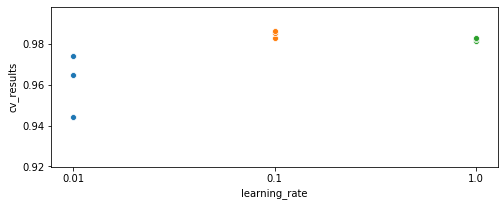

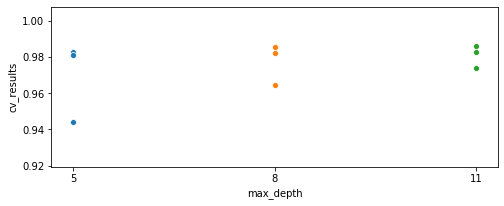

In [ ]:
cv_xgb_1st = get_cv_result(xgb_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_xgb_1st)

In [ ]:
# 1차 그리드 서치 결과 저장
save_as_csv(cv_xgb_1st,'xgb_cv')

In [ ]:
# 2차 그리드 서치

xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47)
xgb_param_grid = {'max_depth': [7,9,10,13,15],'learning_rate':[0.01, 0.1, 1]} 
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='roc_auc', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

xgb_grid.fit(X_train, y_train, early_stopping_rounds=30,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', xgb_grid.best_params_)
print('best score', xgb_grid.best_score_)

[0]	validation_0-error:0.06436
[1]	validation_0-error:0.05559
[2]	validation_0-error:0.05122
[3]	validation_0-error:0.04608
[4]	validation_0-error:0.04326
[5]	validation_0-error:0.04084
[6]	validation_0-error:0.03861
[7]	validation_0-error:0.03623
[8]	validation_0-error:0.03502
[9]	validation_0-error:0.03269
[10]	validation_0-error:0.03109
[11]	validation_0-error:0.02968
[12]	validation_0-error:0.02799
[13]	validation_0-error:0.02750
[14]	validation_0-error:0.02673
[15]	validation_0-error:0.02542
[16]	validation_0-error:0.02357
[17]	validation_0-error:0.02275
[18]	validation_0-error:0.02139
[19]	validation_0-error:0.01960
[20]	validation_0-error:0.01853
[21]	validation_0-error:0.01722
[22]	validation_0-error:0.01620
[23]	validation_0-error:0.01571
[24]	validation_0-error:0.01479
[25]	validation_0-error:0.01407
[26]	validation_0-error:0.01329
[27]	validation_0-error:0.01251
[28]	validation_0-error:0.01169
[29]	validation_0-error:0.01116
[30]	validation_0-error:0.01062
[31]	validation_0-

In [ ]:
xgb = xgb_grid.best_estimator_
# xgb.feature_importances_

In [ ]:
valid_pred = xgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9989802128976244

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[30962,     3],
       [   60, 30825]], dtype=int64)

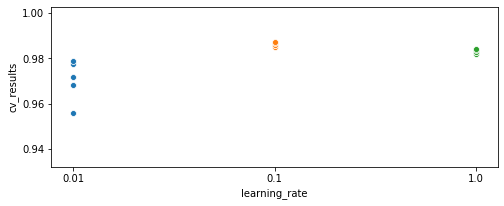

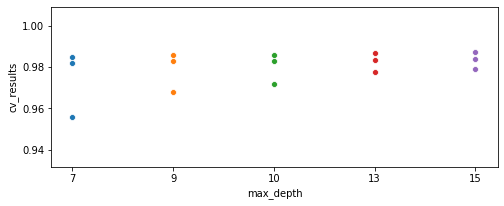

In [ ]:
cv_xgb_2nd = get_cv_result(xgb_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_xgb_2nd)

In [ ]:
# 3차 그리드 서치 - learning_rate 확장

xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47)
xgb_param_grid = {'max_depth': [7,11,15],'learning_rate':[0.06, 0.08, 0.12, 0.14]} 
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='roc_auc', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

xgb_grid.fit(X_train, y_train, early_stopping_rounds=30,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', xgb_grid.best_params_)
print('best score', xgb_grid.best_score_)

[0]	validation_0-error:0.06436
[1]	validation_0-error:0.05442
[2]	validation_0-error:0.05040
[3]	validation_0-error:0.04540
[4]	validation_0-error:0.04162
[5]	validation_0-error:0.04006
[6]	validation_0-error:0.03783
[7]	validation_0-error:0.03604
[8]	validation_0-error:0.03386
[9]	validation_0-error:0.03191
[10]	validation_0-error:0.03007
[11]	validation_0-error:0.02871
[12]	validation_0-error:0.02677
[13]	validation_0-error:0.02513
[14]	validation_0-error:0.02425
[15]	validation_0-error:0.02226
[16]	validation_0-error:0.02047
[17]	validation_0-error:0.01911
[18]	validation_0-error:0.01843
[19]	validation_0-error:0.01775
[20]	validation_0-error:0.01659
[21]	validation_0-error:0.01538
[22]	validation_0-error:0.01441
[23]	validation_0-error:0.01392
[24]	validation_0-error:0.01339
[25]	validation_0-error:0.01193
[26]	validation_0-error:0.01091
[27]	validation_0-error:0.01091
[28]	validation_0-error:0.00975
[29]	validation_0-error:0.00936
[30]	validation_0-error:0.00917
[31]	validation_0-

In [ ]:
xgb = xgb_grid.best_estimator_
xgb.feature_importances_

In [ ]:
valid_pred = xgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9998381509399724

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[30964,     1],
       [    9, 30876]], dtype=int64)

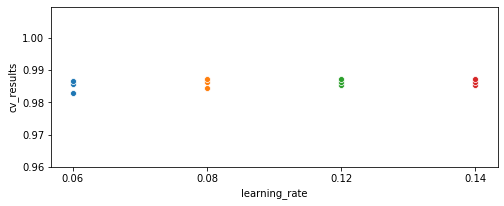

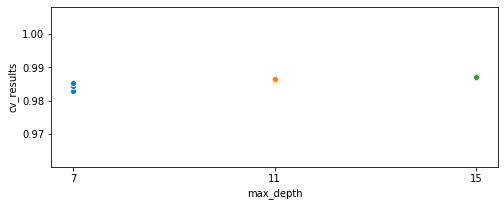

In [ ]:
cv_xgb_3rd = get_cv_result(xgb_grid)
plot_cv_results(cv_xgb_3rd)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47,
                    learning_rate= 0.12, max_depth= 15)
xgb.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=47,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb.feature_importances_

array([1.83741376e-03, 2.76808976e-04, 2.46670330e-04, 1.23096586e-04,
       2.13376945e-03, 9.50409623e-04, 1.03317208e-04, 1.43271056e-04,
       1.34548769e-04, 3.15615267e-04, 3.05096328e-04, 1.34298767e-04,
       1.19277407e-04, 8.03487928e-05, 2.79641186e-04, 1.25874780e-04,
       2.96406884e-04, 2.20840855e-04, 1.45496524e-04, 1.30721164e-04,
       0.00000000e+00, 2.43835137e-04, 0.00000000e+00, 2.93350546e-04,
       1.25392646e-04, 1.10911154e-04, 1.15763381e-04, 1.08988919e-04,
       6.49069552e-04, 2.36406107e-04, 1.05616637e-04, 7.06757011e-04,
       2.81624001e-04, 1.12385074e-04, 2.58387707e-04, 1.27278749e-04,
       1.06215601e-04, 1.72955246e-04, 1.06111678e-04, 1.06289590e-04,
       1.31643159e-04, 1.10486013e-04, 1.11078371e-04, 1.06539781e-04,
       1.25483668e-04, 1.39078082e-04, 2.30338919e-04, 1.58912284e-04,
       9.08633374e-05, 1.30312590e-04, 9.95469745e-05, 1.01447404e-04,
       1.91578001e-04, 1.80150993e-04, 9.02031679e-05, 8.06957250e-05,
      

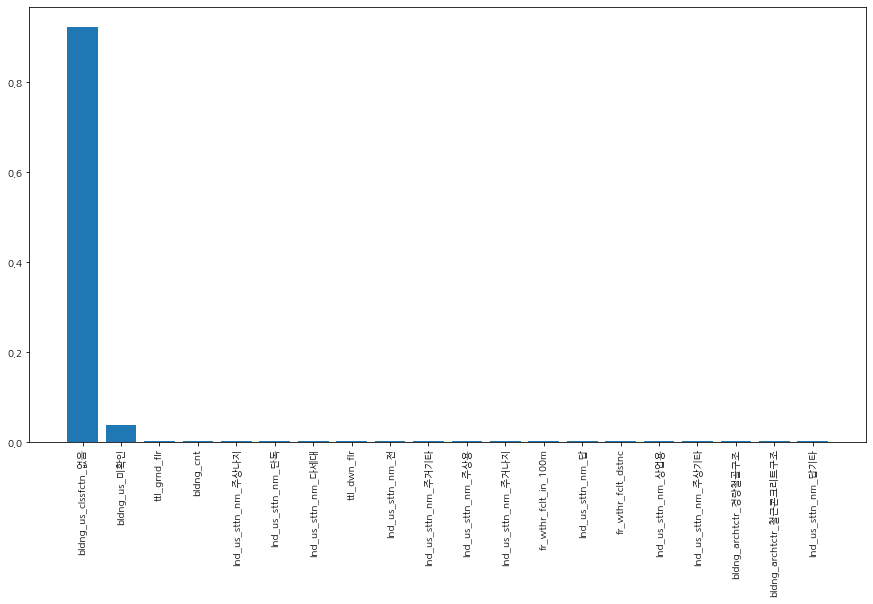

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, xgb.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
feature_pd

feature  importance
124     bldng_us_clssfctn_없음    0.921627
76              bldng_us_미확인    0.037385
4               ttl_grnd_flr    0.002134
0                  bldng_cnt    0.001837
212      lnd_us_sttn_nm_주상나지    0.001570
186        lnd_us_sttn_nm_단독    0.001213
185       lnd_us_sttn_nm_다세대    0.001025
5                ttl_dwn_flr    0.000950
206         lnd_us_sttn_nm_전    0.000901
209      lnd_us_sttn_nm_주거기타    0.000776
213       lnd_us_sttn_nm_주상용    0.000752
210      lnd_us_sttn_nm_주거나지    0.000707
31      fr_wthr_fclt_in_100m    0.000707
187         lnd_us_sttn_nm_답    0.000671
28        fr_wthr_fclt_dstnc    0.000649
194       lnd_us_sttn_nm_상업용    0.000623
211      lnd_us_sttn_nm_주상기타    0.000599
100    bldng_archtctr_경량철골구조    0.000593
115  bldng_archtctr_철근콘크리트구조    0.000589
188       lnd_us_sttn_nm_답기타    0.000547

## Light Gradient Boosting

In [ ]:
# 1차 그리드 서치
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.01,0.1,1],'max_depth' : [5,7,9,11], 'num_leaves' : [30,110,400,800]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.114566	valid_0's binary_logloss: 0.628298
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.108309	valid_0's binary_logloss: 0.574802
[3]	valid_0's binary_error: 0.104574	valid_0's binary_logloss: 0.529151
[4]	valid_0's binary_error: 0.0996265	valid_0's binary_logloss: 0.490581
[5]	valid_0's binary_error: 0.0971528	valid_0's binary_logloss: 0.457429
[6]	valid_0's binary_error: 0.0951642	valid_0's binary_logloss: 0.429091
[7]	valid_0's binary_error: 0.0949702	valid_0's binary_logloss: 0.403803
[8]	valid_0's binary_error: 0.0933695	valid_0's binary_logloss: 0.38159
[9]	valid_0's binary_error: 0.0920114	valid_0's binary_logloss: 0.362341
[10]	valid_0's binary_error: 0.0898288	valid_0's binary_logloss: 0.345676
[11]	valid_0's binary_error: 0.0874036	valid_0's binary_logloss: 0.329151
[12]	valid_0's binary_error: 0.0845904	valid_0's binary_logloss: 0.316053
[13]	valid_0's binary_error: 0.0840083	valid_0's binary_logloss:

In [ ]:
lgbm_grid.cv_results_

{'mean_fit_time': array([13.8133316 , 13.54662704, 11.609236  , 10.15438932, 10.94459224,
        11.92459732, 11.41916901, 12.12994862, 14.0415507 , 17.67569852,
        21.30020452, 20.98750728, 16.61570299, 26.08711976, 35.58774525,
        36.44572073, 12.74201196, 12.11997151, 11.53057271, 11.92575186,
        13.21366376, 14.31329304, 14.58822602, 14.08830482, 15.09945959,
        20.25246239, 21.6444571 , 22.8506093 , 15.2422083 , 21.93388104,
        30.49170601, 30.58204448,  9.90064478, 10.96530831, 11.31498128,
        11.22263896, 10.61944407, 15.02069885, 15.00577396, 14.47266906,
        11.61284244, 19.26435047, 14.64292252, 15.16727555, 12.23818904,
        17.5563125 , 24.94021142, 23.05961138]),
 'std_fit_time': array([0.49127461, 0.39934982, 1.70987253, 0.53366958, 0.71328616,
        0.60366756, 0.59361119, 1.73184739, 0.81848974, 1.42827433,
        0.95868407, 0.63976401, 1.83613653, 1.0928612 , 2.75239924,
        2.50840116, 0.50898894, 0.5662233 , 0.16048257, 0

In [ ]:
lgb = lgbm_grid.best_estimator_

valid_pred = lgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9703684861889927

In [ ]:
print(f1_score(y_valid, valid_pred, pos_label=1))

0.9697110056078477


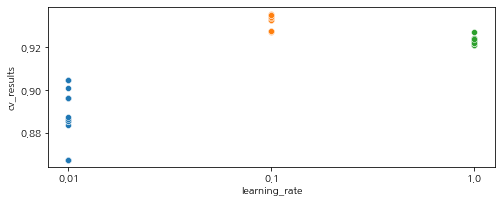

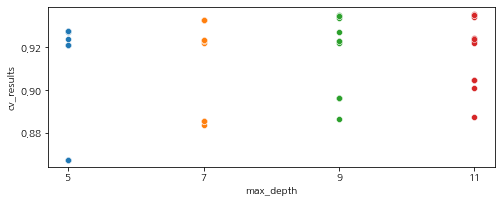

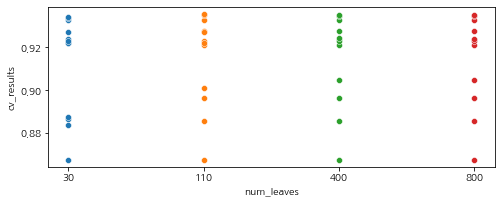

In [ ]:
cv_lgb_1st = get_cv_result(lgbm_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_lgb_1st)

In [ ]:
# 2차 그리드 서치
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.01,0.1,1],'max_depth' : [13,15,17,19], 'num_leaves' : [30,110,400,800]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.0850269	valid_0's binary_logloss: 0.621281
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.0772663	valid_0's binary_logloss: 0.561747
[3]	valid_0's binary_error: 0.0730465	valid_0's binary_logloss: 0.511845
[4]	valid_0's binary_error: 0.0688267	valid_0's binary_logloss: 0.468251
[5]	valid_0's binary_error: 0.0641218	valid_0's binary_logloss: 0.430887
[6]	valid_0's binary_error: 0.0599505	valid_0's binary_logloss: 0.398435
[7]	valid_0's binary_error: 0.0581559	valid_0's binary_logloss: 0.370159
[8]	valid_0's binary_error: 0.0564583	valid_0's binary_logloss: 0.344574
[9]	valid_0's binary_error: 0.05316	valid_0's binary_logloss: 0.322192
[10]	valid_0's binary_error: 0.0513654	valid_0's binary_logloss: 0.301928
[11]	valid_0's binary_error: 0.0502013	valid_0's binary_logloss: 0.283944
[12]	valid_0's binary_error: 0.0489887	valid_0's binary_logloss: 0.267676
[13]	valid_0's binary_error: 0.0476791	valid_0's binary_loglos

In [ ]:
lgbm_grid.cv_results_

{'mean_fit_time': array([17.44121283, 25.28191692, 39.51928532, 40.33132303, 13.54388505,
        21.61281878, 33.352507  , 51.47515464, 14.33490127, 25.53613257,
        39.54918218, 57.28298569, 15.94672406, 24.15198946, 43.53496945,
        61.33278173, 16.69523066, 23.84500098, 34.48752147, 41.54847622,
        15.52142137, 21.38062674, 36.93187481, 50.12353373, 14.50308812,
        21.25331533, 39.44209617, 57.10094208, 15.21091896, 24.13107747,
        41.08379191, 62.06459397, 11.31212425, 15.96439672, 28.20068049,
        30.9244653 , 12.43267727, 19.27586347, 28.12664056, 35.75748831,
        13.75433367, 22.1602301 , 33.36396241, 36.08181232, 12.80197626,
        22.95549208, 26.24299937, 24.78321016]),
 'std_fit_time': array([0.62469144, 1.29252065, 3.02421104, 3.14388912, 0.17095975,
        1.50050781, 2.77044593, 4.24179123, 1.28175547, 1.36676806,
        0.21593821, 4.5761629 , 0.62124681, 1.56707442, 2.84884776,
        0.31601768, 2.56350476, 1.50071716, 0.54793381, 2

In [ ]:
lgb = lgbm_grid.best_estimator_

valid_pred = lgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9996438400518051

In [ ]:
print(f1_score(y_valid, valid_pred, pos_label=1))

0.9996437131567014


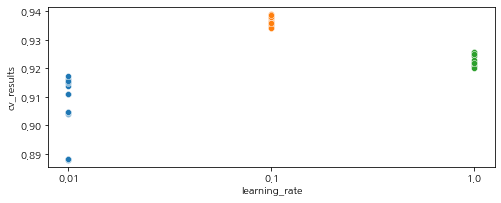

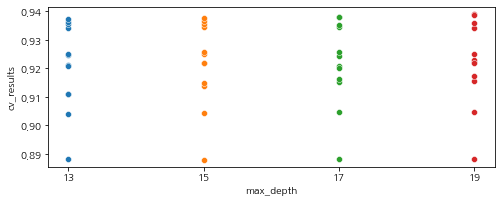

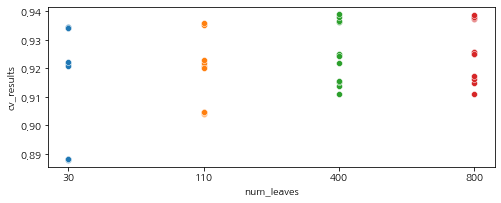

In [ ]:
cv_lgb_2nd = get_cv_result(lgbm_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_lgb_2nd)

In [ ]:
save_as_csv(cv_lgb_2nd,'lgb_cv')

In [ ]:
# 3차 그리드 서치
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.01,0.1,1],'max_depth' : [11,15,19,23], 'num_leaves' : [400,800,1600,3000]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.0758112	valid_0's binary_logloss: 0.617494
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.0634428	valid_0's binary_logloss: 0.554773
[3]	valid_0's binary_error: 0.0562157	valid_0's binary_logloss: 0.501667
[4]	valid_0's binary_error: 0.0511714	valid_0's binary_logloss: 0.456155
[5]	valid_0's binary_error: 0.0454964	valid_0's binary_logloss: 0.416135
[6]	valid_0's binary_error: 0.0435563	valid_0's binary_logloss: 0.381293
[7]	valid_0's binary_error: 0.039094	valid_0's binary_logloss: 0.350309
[8]	valid_0's binary_error: 0.0354077	valid_0's binary_logloss: 0.323033
[9]	valid_0's binary_error: 0.03274	valid_0's binary_logloss: 0.298589
[10]	valid_0's binary_error: 0.0295387	valid_0's binary_logloss: 0.276734
[11]	valid_0's binary_error: 0.026677	valid_0's binary_logloss: 0.256956
[12]	valid_0's binary_error: 0.0253189	valid_0's binary_logloss: 0.239231
[13]	valid_0's binary_error: 0.0235243	valid_0's binary_logloss:

In [ ]:
lgbm_grid.cv_results_

{'mean_fit_time': array([ 29.74200082,  28.81918806,  37.28273189,  42.40655053,
         50.50017262, 113.58904594, 110.30133957,  94.66693288,
         51.21547598,  74.53209305, 213.25523078, 300.3369512 ,
         51.48575956, 100.60286182, 296.41315949, 293.02437693,
         41.73004836,  39.92413425,  41.87671494,  40.41622376,
         45.49465472,  74.05645782,  89.55379528,  85.79151648,
         55.77841502, 143.6647197 , 299.88068652, 307.26876706,
         56.63292038, 155.1764276 , 460.05407774, 423.55227363,
         40.7628569 ,  36.59131515,  42.89064127,  44.63883364,
         41.51251644,  45.89058429,  56.96355677,  62.9703483 ,
         31.47276515,  52.09447134, 110.14708424, 127.78105998,
         35.96252853,  55.31441247, 106.38598394,  87.72747952]),
 'std_fit_time': array([ 1.69125554,  1.30862185,  6.88932797,  2.60137955,  1.14570738,
        13.27146273,  4.33505986, 16.47004297,  3.9267339 ,  9.72822467,
        15.3720426 , 15.14324876,  2.90895491,  2.5

In [ ]:
lgb = lgbm_grid.best_estimator_

valid_pred = lgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9999677054739221

In [ ]:
print(f1_score(y_valid, valid_pred, pos_label=1))

0.9999676228712038


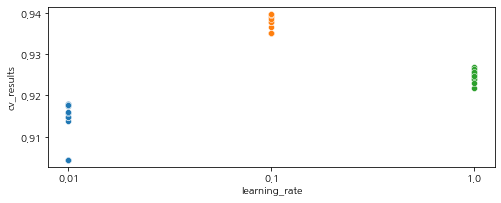

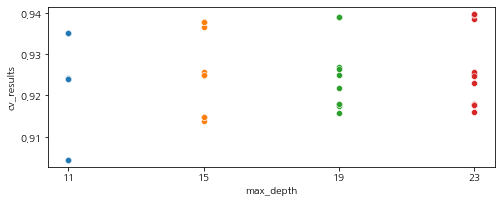

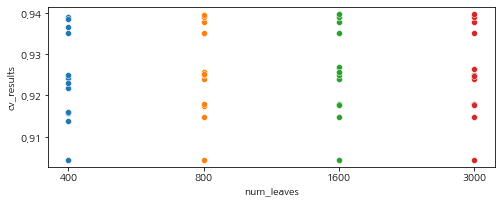

In [ ]:
cv_lgb_3rd = get_cv_result(lgbm_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_lgb_3rd)

In [ ]:
save_as_csv(cv_lgb_3rd,'lgb_cv')

In [ ]:
# 4차 그리드 서치
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.06,0.08,0.12,0.14],'max_depth' : [12,17,22], 'num_leaves' : [400,800,1600,3000]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.0761022	valid_0's binary_logloss: 0.60405
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.0632003	valid_0's binary_logloss: 0.532586
[3]	valid_0's binary_error: 0.0562157	valid_0's binary_logloss: 0.474084
[4]	valid_0's binary_error: 0.0484067	valid_0's binary_logloss: 0.424335
[5]	valid_0's binary_error: 0.0429257	valid_0's binary_logloss: 0.382049
[6]	valid_0's binary_error: 0.0404036	valid_0's binary_logloss: 0.346222
[7]	valid_0's binary_error: 0.0376873	valid_0's binary_logloss: 0.315037
[8]	valid_0's binary_error: 0.0356502	valid_0's binary_logloss: 0.28783
[9]	valid_0's binary_error: 0.0327885	valid_0's binary_logloss: 0.263947
[10]	valid_0's binary_error: 0.0295872	valid_0's binary_logloss: 0.242423
[11]	valid_0's binary_error: 0.0272106	valid_0's binary_logloss: 0.223743
[12]	valid_0's binary_error: 0.0253189	valid_0's binary_logloss: 0.206661
[13]	valid_0's binary_error: 0.0238638	valid_0's binary_loglos

In [ ]:
lgbm_grid.cv_results_

{'mean_fit_time': array([ 32.98295158,  33.81592846,  32.91934973,  33.0339359 ,
         31.11431581, 128.02997738, 158.71894151, 135.13186711,
         45.6495468 ,  90.65913147, 430.60764062, 409.92810756,
         53.57634139,  56.53109813,  51.13134885,  54.1180703 ,
         47.83578545, 113.9968273 , 185.30428332, 186.71249235,
         63.56798142, 102.79635942, 426.64268351, 502.14631814,
         42.9829756 ,  47.83762527,  77.16853601,  86.93593854,
         54.26649475, 106.62498254, 154.89030099, 133.76737946,
         60.5622825 , 141.92680997, 390.71840405, 359.37047654,
         44.95317245,  51.70087552,  50.52925175,  51.26013625,
         54.58186644,  91.37484884, 144.02992606, 131.58963782,
         53.76654989,  93.10987729, 322.7032395 , 283.78453571]),
 'std_fit_time': array([ 1.79518051,  3.2093465 ,  2.70071932,  2.02408637,  2.06244194,
        13.40103556,  9.51836547, 29.70959729,  3.12163418, 15.18474969,
        22.39221904, 11.09525111,  0.92161416,  2.5

In [ ]:
lgb = lgbm_grid.best_estimator_

valid_pred = lgb.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.9998543400285266

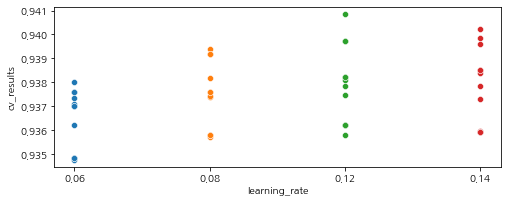

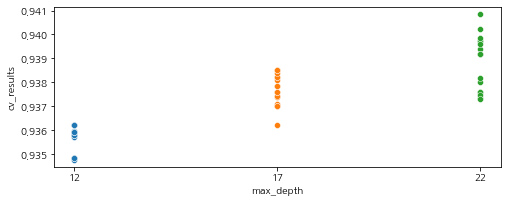

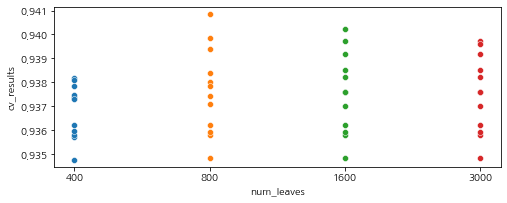

In [ ]:
cv_lgb_4th = get_cv_result(lgbm_grid)
# print(cv_lgb_1st.head())
plot_cv_results(cv_lgb_4th)

In [ ]:
save_as_csv(cv_lgb_4th,'lgb_cv')

In [ ]:
lgb_final= lgbm_grid.best_estimator_

In [ ]:
print(f1_score(y_valid, valid_pred, pos_label=1))

0.9998542816896847


In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, lgb_final.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

In [ ]:
feature_pd

feature  importance
6                 tmprtr        4472
10                  hmdt        4404
36       no_tbc_zn_dstnc        3894
28    fr_wthr_fclt_dstnc        3865
26         fr_sttn_dstnc        3823
30            cctv_dstnc        3730
25                hm_cnt        3727
8                wnd_spd        3719
33     tbc_rtl_str_dstnc        3702
35            ahsm_dstnc        3575
34  sft_emrgnc_bll_dstnc        3529
27          bldng_ar_prc        3381
1               bldng_ar        3186
2                 ttl_ar        2973
3                 lnd_ar        2938
9              wnd_drctn        2913
62                 month        2832
0              bldng_cnt        1929
29             fr_mn_cnt        1799
37      bldng_cnt_in_50m        1519

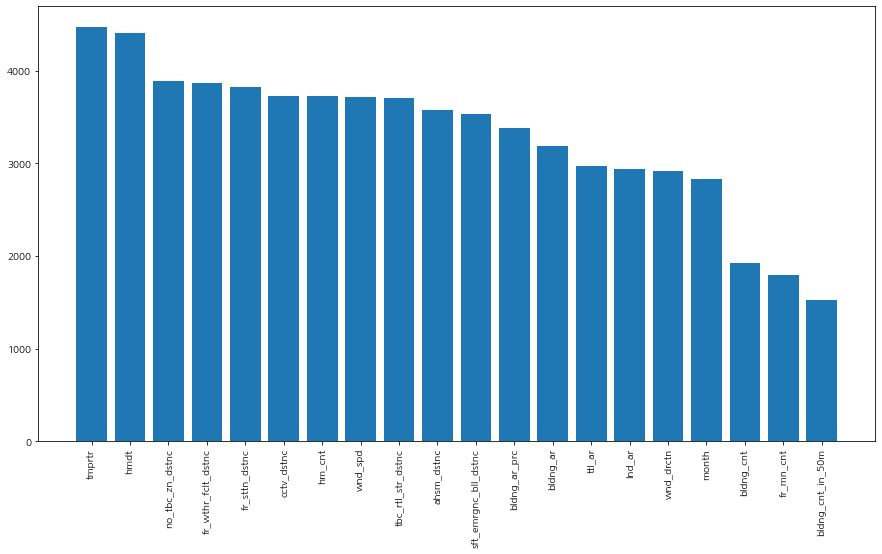

In [ ]:
fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()

## Test Set 검증

### 1) XGB Model

In [ ]:
X_test_scd = X_test[X_train_smote.columns]

In [ ]:
train_col = set(X_train_smote.columns)
test_col = set(X_test_scd.columns)

# test_col.difference(train_col)
# train_col.difference(test_col)

set()

In [ ]:
X_test_scd = X_test[X_scd.columns]
test_pred = lgb_final.predict(X_test_scd)
fpr, tpr, threshold = roc_curve(y_test,test_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.5499652612421663

In [ ]:
print('score : ',lgb_final.score(X_test_scd,y_test))
print('f1_score : ',f1_score(y_test, test_pred, pos_label=1))

score :  0.6504783995360974
f1_score :  0.2919236417033774


In [ ]:
confusion_matrix(y_test,test_pred)

array([[3990, 1636],
       [ 775,  497]])

### 2) LGB Model

In [ ]:
test_pred = xgb.predict(X_test_scd)
fpr, tpr, threshold = roc_curve(y_test,test_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.6029343211102093

In [ ]:
xgb.score(X_test_scd,y_test)

0.6113366193099449

In [ ]:
confusion_matrix(y_test,test_pred)

array([[3467, 2159],
       [ 522,  750]])

In [ ]:
print(f1_score(y_test, test_pred, pos_label=1))

0.3587658454915092


# Model 적용(결측치 처리 version2)